##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Tuning Quickstart with Python

In this notebook, you'll learn how to get started with the tuning service using the Python client library for the Gemini API. Here, you'll learn how to tune the text model behind the Gemini API's text generation service.

**Note**: At this time, tuning is only available for the `gemini-1.0-pro-001` model.

## Setup

### Authenticate

The Gemini API lets you tune models on your own data. Since it's your data and
your tuned models this needs stricter access controls than API-Keys can provide.

Before you can run this tutorial, you'll need to
[setup OAuth for your project](https://ai.google.dev/palm_docs/oauth_quickstart).


In Colab the easiest wat to get setup is to copy the contents of your `client_secret.json` file into Colab's "Secrets manager" (under the key icon in the left panel) with the secret name `CLIENT_SECRET`.

This gcloud command turns the `client_secret.json` file into credentials that can be used to authenticate with the service.

> Important: If you're running this in Colab, **don't just click the link it prints**. That will fail. Follow the instructions and copy the `gcloud` command it prints to your local machine and run it there, then paste the output from your local machine back here.


In [4]:
import os
if 'COLAB_RELEASE_TAG' in os.environ:

  # Use `--no-browser` in colab
  !gcloud auth application-default login --no-browser --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'
else:
  !gcloud auth application-default login --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'

You are authorizing client libraries without access to a web browser. Please run the following command on a machine with a web browser and copy its output back here. Make sure the installed gcloud version is 372.0.0 or newer.

gcloud auth application-default login --remote-bootstrap="https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=797569668330-tpt3t4g98dv6vb5umd9qotb414egh4dv.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.tuning&state=TJJfCBuI7tftsQVSy95b5bREmPFnbv&access_type=offline&code_challenge=3_juJmBKMasay_BCsrzr2t1JWq8SbtBP91DKiccONE8&code_challenge_method=S256&token_usage=remote"


Enter the output of the above command: https://localhost:8085/?state=TJJfCBuI7tftsQVSy95b5bREmPFnbv&code=4/0AcvDMrDuywuI_G13LJuk3_g5rwhqeFWPP3VlQ_NwihaQay6fdlRjuhvSLlsOEcQz6J3UIw&scope=https://www.googleapis.com/auth/cloud-platform%20https://www.googleapis.com/auth/generati

### Install the client library

In [5]:
!pip install -q -U google-generativeai

### Import libraries

In [6]:
import google.generativeai as genai

print('Available base models:', [m.name for m in genai.list_models()])

Available base models: ['models/chat-bison-001', 'models/text-bison-001', 'models/embedding-gecko-001', 'models/gemini-1.0-pro', 'models/gemini-1.0-pro-001', 'models/gemini-1.0-pro-latest', 'models/gemini-1.0-pro-vision-latest', 'models/gemini-1.5-flash', 'models/gemini-1.5-flash-001', 'models/gemini-1.5-flash-latest', 'models/gemini-1.5-pro', 'models/gemini-1.5-pro-001', 'models/gemini-1.5-pro-latest', 'models/gemini-pro', 'models/gemini-pro-vision', 'models/embedding-001', 'models/text-embedding-004', 'models/aqa']


In [7]:
!gcloud --version

Google Cloud SDK 484.0.0


You can check you existing tuned models with the `genai.list_tuned_model` method.

In [8]:
print('My tuned models:', [m.name for m in genai.list_tuned_models()])

My tuned models: []


## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [9]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]
base_model

Model(name='models/gemini-1.0-pro-001',
      base_model_id='',
      version='001',
      display_name='Gemini 1.0 Pro 001 (Tuning)',
      description=('The best model for scaling across a wide range of tasks. This is a stable '
                   'model that supports tuning.'),
      input_token_limit=30720,
      output_token_limit=2048,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=0.9,
      max_temperature=None,
      top_p=1.0,
      top_k=None)

In [10]:
base_model.name

'models/gemini-1.0-pro-001'

In [12]:
base_model.output_token_limit

2048

In [13]:
prompt= ["The headphones are really great, but the delivery was very slow.",
"I love the design of the laptop. The shipment was on time too!",
"The book arrived damaged, very disappointed. The shipping was okay though.",
"The quality of the furniture is top-notch! The courier service was terrible.",
"The coffee maker works like a charm! Thank you for the fast delivery.",
"Absolutely hate the sweater, feels so cheap. Kinda glad the shipping was fast though.",
"The perfume smells amazing. The delivery was quick and well-packaged.",
"The bicycle is durable and well-built. However, shipping took longer than expected.",
"Sofa is not comfortable at all. Shipping was decent.",
"Very pleased with my new TV! Shipping took ages to arrive.",
"The gaming console is a dream come true. Shipping came sooner than expected!",
"The jacket fits perfectly. The shipping was extremely slow!",
"The kettle leaks water, very poor quality. Shipping was quick though.",
"Love my new shoes, they fit perfectly. Delivery was late, however.",
"The vacuum cleaner is very powerful. Delivery was smooth and on time.",
"The tablet is amazing, but delivery took forever to arrive.",
"Very dissatisfied with the camera quality. Shipping was mediocre.",
"The bed frame is sturdy and beautiful. Delivery service was abysmal.",
"Thrilled with the microwave performance. Shipping was prompt.",
"The printer constantly malfunctions. Delivery was okay.",
"These sunglasses are stylish and high-quality. Shipping was a nightmare.",
"The blender is fantastic for smoothies. Shipping was hassle-free.",
"Really disappointed in the headphones. Delivery was alright though.",
"The shoes are exactly what I needed, but the shipment was delayed.",
"Beautiful watch, works great. Delivery process was frustratingly slow.",
"Terrible experience with the dishwasher. The shipping was reasonable.",
"The monitor is excellent for gaming. The package arrived on time.",
"The hairdryer is faulty and doesn't work. Shipping was punctual.",
"So happy with the noise-cancelling feature of these earbuds. Delivery was late.",
"This fitness tracker is just amazing. The delivery was quick and efficient.",
"Really subpar quality of the backpack. Shipping was substandard too.",
"The smart speaker works wonders! Delivery was on point.",
"Lovely dress, fits just right. Shipping was delayed a bit.",
"Hated the tablet, very slow and unresponsive. Shipping was swift.",
"The air fryer is brilliant. Delivery service was a disaster.",
"These curtains are perfect for my room. Shipping was straightforward.",
"Very poor quality camera lens. The delivery was acceptable.",
"The smartwatch is very functional. Package arrived so late.",
"The dress wasn't what I expected. Shipping was on time.",
"This gaming mouse is a game-changer. Delivery was slower than anticipated.",
"The grill did not work properly. Shipment came faster than I thought it would.",
"These boots are extremely comfy. Shipping experience was great too!",
"The office chair was missing parts. Delivery was prompt.",
"I love this camera! Shipping took a while to arrive.",
"This baby stroller is very high-quality. Shipping was slower than promised.",
"Not happy with the table lamp, it stopped working. Shipping was fast, though.",
"Perfect oven for our needs! Delivery was serviceable.",
"The rug feels cheap and looks bad. Delivery time was sufficient.",
"Extremely happy with the new blender. Packaging and delivery were fine.",
"My new winter coat is perfect. The shipping was the worst.",
"This electric scooter is so much fun! Shipping was on time.",
"This chair is so comfortable, I love it!",
"The camera arrived late but is in perfect condition.",
"I'm really impressed with the quality of this phone case.",
"The delivery was really fast, thank you!",
"Ordered a watch and it arrived damaged. Disappointed!",
"The carpet fits perfectly in my living room.",
"The package arrived later than expected.",
"Very satisfied with this water bottle's design.",
"The courier service was quite efficient.",
"The shipping was a disaster, it took forever!",
"The tablet is extremely fast and responsive, but the delivery was really slow.",
"Amazing camera quality! Shipping was prompt and hassle-free.",
"The refrigerator is faulty, doesn't cool properly. Shipping was on time though.",
"Fantastic sound system, but the package arrived much later than expected.",
"Very satisfied with this gaming laptop! Shipping was smooth and quick.",
"Disappointed with the quality of this shirt. Shipping was fast, though.",
"The garden tools are very durable and well-made. Delivery was efficient.",
"The TV stand looks great, but shipping took forever to arrive.",
"These running shoes are uncomfortable. Delivery was okay.",
"Thrilled with the coffee machine! The courier service was horrible, though.",
"The lamp is beautiful and works perfectly. Delivery was fast.",
"Very unhappy with the mattress, it's too firm. Delivery was on time.",
"The headphones sound incredible. The shipping was delayed, unfortunately.",
"This backpack is very functional and stylish. Delivery was great too.",
"The washing machine broke down after a week. Shipping was fast.",
"Absolutely love this blender, but shipping was a nightmare.",
"The winter boots are of poor quality. Delivery was quick, though.",
"Very impressed with the smartphone! Shipping was also very fast.",
"The electric kettle stopped working after a month. Delivery was timely.",
"These wireless earbuds are fantastic! Delivery took longer than expected.",
"The air conditioner cools efficiently. Shipping was mediocre.",
"Not happy with this vacuum cleaner. Shipping was fast, however.",
"This microwave oven is a great buy! The courier service was terrible.",
"The desk is sturdy and stylish. Delivery was prompt.",
"Very dissatisfied with the printer quality. Shipping was fine.",
"The camera tripod is well-built and stable. The delivery was slow.",
"This smartwatch has many useful features. Shipping was prompt.",
"The electric scooter is a lot of fun! Shipping took a while, though.",
"Extremely disappointed with the laptop stand. Delivery was fast.",
"The kitchen mixer is perfect for my needs. Shipping was delayed.",
"The curtains block out light perfectly. Delivery was swift.",
"The watch stopped working after a week. Shipping was punctual.",
"Very happy with this gaming chair! The shipping was slow, however.",
"The bookshelf is elegant and sturdy. Delivery was on time.",
"The blender jar cracked after one use. Shipping was quick.",
"These slippers are so comfortable! Delivery was on point.",
"The kitchen scale is inaccurate. Shipping was acceptable.",
"Really pleased with this photo frame. The shipping was delayed.",
"The suitcase is very spacious and durable. Delivery was on time.",
"Disappointed in the quality of this hoodie. Shipping was smooth.",
"The lawnmower works great! The delivery was a bit slow.",
"This electric toothbrush is amazing. Delivery was quick and easy.",
"The mirror arrived shattered. Shipping was on time, though.",
"These jeans fit perfectly. The shipping was very slow.",
"The blender works perfectly. Delivery was late, however.",
"The gaming headset is top-notch! Shipping was delayed, though.",
"This tablet case is very durable. Delivery was on time.",
"The drill stopped working after a month. Delivery was fast.",
"Love the new rug! Shipping was slower than expected.",
"The pressure cooker is excellent. Delivery was quick and smooth.",
"The gym bag is very flimsy. Shipping was fast, though.",
"This monitor is perfect for my needs. Shipping took a while.",
"The gaming console is faulty. Delivery was on time.",
"Very happy with this office desk. Shipping was efficient.",
"The phone case is of very poor quality. Shipping was quick.",
"The electric grill is fantastic! The delivery took forever.",
"These earbuds have excellent sound quality. Shipping was delayed.",
"The laptop case is well-made. Delivery was on time.",
"The water bottle leaks. Shipping was fast, though.",
"This jacket is stylish and warm. Delivery was delayed, however.",
"The vacuum cleaner is very powerful. Delivery was fast.",
"Very dissatisfied with this smartwatch. The shipping was slow.",
"The desk chair is extremely comfortable. Delivery was quick.",
"The toaster broke after a week. Shipping was on time.",
"The new keyboard is excellent! Delivery was faster than expected.",
"The blender jar cracked easily. Shipping was fast, however.",
"Absolutely love this sofa. Shipping took longer than anticipated.",
"This router has poor signal strength. Delivery was on time.",
"The smart bulb is very bright and energy-efficient. Delivery was quick.",
"The carpet is of low quality. Delivery was punctual.",
"The electric shaver works wonderfully. Shipping was delayed.",
"These headphones are very uncomfortable. Shipping was fast.",
"This smartwatch exceeded my expectations. Delivery was smooth.",
"The blender motor burned out quickly. Delivery was fast, though.",
"Love this hair straightener! Delivery was a bit late."]

In [14]:
target=["{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product:positive, shipping: neutral}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: neutral}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: positive, shipping: None}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: None}",
"{product: None, shipping: positive}",
"{product: negative, shipping: None}",
"{product: positive, shipping: None}",
"{product: None, shipping: negative}",
"{product: positive, shipping: None}",
"{product: None, shipping: positive}",
"{product: None, shipping: negative}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: neutral}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: neutral}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: negative}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: positive}",
"{product: negative, shipping: positive}",
"{product: positive, shipping: negative}"]

In [15]:
len(target)

136

In [16]:
system="Classify the text based on delimited by angle brackets comments about the product and shipping as positive, negative, neutral, and None."

# commonly used delimiters:
# triple quotes: """
# triple backticks: '''
# riple dashes: ___
# angle brackets : <>
# curly brackets: {}
# XML tags: <tag> </tag> ---> <text>This is sentence</text>

In [17]:
def prompt_new(prompt):
  new_prompt=[system + '<' + i +'>' for i in prompt]
  return new_prompt

In [18]:
new_prompt=prompt_new(prompt)

In [19]:
new_prompt[0]

'Classify the text based on delimited by angle brackets comments about the product and shipping as positive, negative, neutral, and None.<The headphones are really great, but the delivery was very slow.>'

In [21]:
import pandas as pd
my_dict={"text_input":new_prompt, "output":target}
df=pd.DataFrame(my_dict)
df
# text input ve output sabt sütun ismi değerleri

,text_input,output
0,Classify the text based on delimited by angle ...,"{product: positive, shipping: negative}"
1,Classify the text based on delimited by angle ...,"{product: positive, shipping: positive}"
2,Classify the text based on delimited by angle ...,"{product: negative, shipping: neutral}"
3,Classify the text based on delimited by angle ...,"{product: positive, shipping: negative}"
4,Classify the text based on delimited by angle ...,"{product: positive, shipping: positive}"
...,...,...
131,Classify the text based on delimited by angle ...,"{product: positive, shipping: negative}"
132,Classify the text based on delimited by angle ...,"{product: negative, shipping: positive}"
133,Classify the text based on delimited by angle ...,"{product: positive, shipping: positive}"
134,Classify the text based on delimited by angle ...,"{product: negative, shipping: positive}"


In [22]:
df.to_csv("data.csv")

In [23]:
import random

name = f'generatenum{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model=base_model.name,
    description='NER_person_time',
    display_name=name,
    id=name,
    training_data="/content/data.csv",
    epoch_count=5,
    batch_size=4,
    learning_rate=0.001,
    temperature=0.0,
    top_p=1.0

)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [24]:
name

'generatenum1375'

In [25]:
models=[m.name for m in genai.list_tuned_models()]
models

['tunedModels/generatenum1375']

In [26]:
models[-1]

'tunedModels/generatenum1375'

In [27]:
model = genai.get_tuned_model(f"tunedModels/{name}") #models[-1]

model
# sadece train data kullanabilioruz test ve validtaion yok

TunedModel(name='tunedModels/generatenum1375',
           source_model='models/gemini-1.0-pro-001',
           base_model='models/gemini-1.0-pro-001',
           display_name='generatenum1375',
           description='NER_person_time',
           temperature=0.0,
           top_p=1.0,
           top_k=0,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2024, 7, 22, 13, 12, 39, 312458, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 7, 22, 13, 13, 36, 678927, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 7, 22, 13, 12, 40, 249109, tzinfo=datetime.timezone.utc),
                                  complete_time=None,
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=5,
                                                                  batch_size=4,
                                                     

In [28]:
model.name

'tunedModels/generatenum1375'

In [29]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [30]:
operation.metadata

total_steps: 170
tuned_model: "tunedModels/generatenum1375"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [31]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/170 [00:00<?, ?it/s]

In [32]:
operation.result()

TunedModel(name='tunedModels/generatenum1375',
           source_model='models/gemini-1.0-pro-001',
           base_model='models/gemini-1.0-pro-001',
           display_name='generatenum1375',
           description='NER_person_time',
           temperature=0.0,
           top_p=1.0,
           top_k=0,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2024, 7, 22, 13, 12, 39, 312458, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 7, 22, 13, 21, 7, 748864, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 7, 22, 13, 12, 40, 249109, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2024, 7, 22, 13, 21, 7, 748864, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=5,
                                                             

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
#operation.cancel()

True

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://generativeai.devsite.corp.google.com/guide/model_tuning_guidance#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

In [33]:
snapshots = pd.DataFrame(operation.result().tuning_task.snapshots)
snapshots

,step,mean_loss,epoch,compute_time
0,1,18.060083,0,2024-07-22 13:12:41.925602+00:00
1,2,15.293777,0,2024-07-22 13:12:44.685129+00:00
2,3,10.379304,0,2024-07-22 13:12:47.538934+00:00
3,4,5.014498,0,2024-07-22 13:12:50.351668+00:00
4,5,1.962932,0,2024-07-22 13:12:53.035758+00:00
...,...,...,...,...
165,166,0.012918,4,2024-07-22 13:20:51.639605+00:00
166,167,0.018196,4,2024-07-22 13:20:54.559377+00:00
167,168,0.016634,4,2024-07-22 13:20:57.403411+00:00
168,169,0.021289,4,2024-07-22 13:21:00.539179+00:00


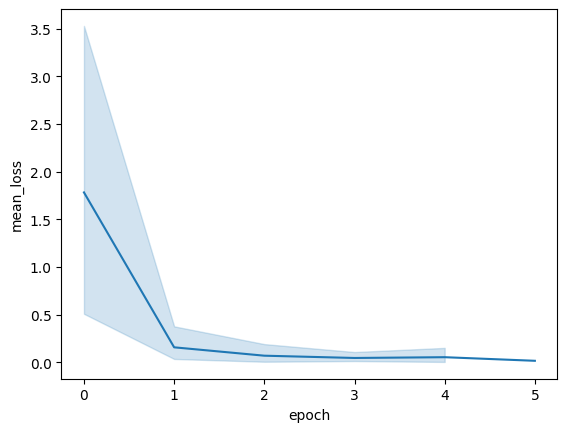

In [34]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(operation.result().tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss');


## Evaluate your model

You can use the `genai.generate_text` method and specify the name of your model to test your model performance.

In [35]:
model2 = genai.GenerativeModel(model_name=model.name)

In [36]:
model.name

'tunedModels/generatenum1375'

In [37]:
system

'Classify the text based on delimited by angle brackets comments about the product and shipping as positive, negative, neutral, and None.'

In [38]:
text1="the phone is very nice but kargo is bad"

In [39]:
prompt1=prompt_new([text1])
prompt1

['Classify the text based on delimited by angle brackets comments about the product and shipping as positive, negative, neutral, and None.<the phone is very nice but kargo is bad>']

In [40]:
result = model2.generate_content(prompt1)
result.text

'{product: positive, shipping: negative}'

In [41]:
text2=prompt="phone is ok"

In [42]:
prompt2=prompt_new([text2])
result = model2.generate_content(prompt2)
result.text


'{product: None, shipping: None}'

In [43]:
text3="The phone is good but the shipping and customer services were very bad."

In [44]:
prompt3=prompt_new([text3])
result = model2.generate_content(prompt3)
result.text

'{product: positive, shipping: negative}'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/docs/model_tuning_guidance) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [45]:
genai.update_tuned_model(f'{model.name}', {"description":"Multilabel classification for product and shipping."});

In [46]:
model3 = genai.get_tuned_model(f'{model.name}')

model3.description

'Multilabel classification for product and shipping.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [47]:
genai.delete_tuned_model(f'{model.name}')

The model no longer exists:

In [48]:
try:
  m = genai.get_tuned_model(f'{model.name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 Tuned model tunedModels/generatenum1375 does not exist.
